# Modelos de Regressão para Consumo Energético

Notebook organizado com os seguintes elementos:

- XGBoost (modelo base)
- Random Forest
- MLP Regressor
- Comparação de modelos
- Tuning avançado do XGBoost
- Remoção de outliers e novas features
- Versões alternativas baseadas em séries temporais
- Códigos de diagnóstico
- Gráficos de avaliação relevantes


## 1. Imports e configuração inicial

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

In [5]:
plt.style.use("default")

DATA_DIR = Path("Data")
RAW_FILE = DATA_DIR / "consumo15m_11_2025.csv"  

INTERIM_DIR = Path("interim")
PROCESSED_DIR = Path("processed")

INTERIM_DIR.mkdir(exist_ok=True)
PROCESSED_DIR.mkdir(exist_ok=True)

In [7]:
df_raw = pd.read_csv(RAW_FILE)

df = df_raw.copy()

time_col = "tstamp"       
power_col = "PotActiva"
react_ind_col = "PotReactIndut"
react_cap_col = "PotReactCapac"
consumption_col = "DadosdeConsumo"

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])
df = df.sort_values(["CPE", time_col])

for col in [power_col, react_ind_col, react_cap_col, consumption_col]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print('Shape after basic cleaning:', df.shape)
df = df.sort_values("tstamp")
df


Shape after basic cleaning: (5940182, 6)


,CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
8732,PT0002000068856906VS,2022-12-31 00:15:00,NaN,4.000,0.0,1.0
191642,PT0002000075637532JB,2022-12-31 00:15:00,NaN,1.000,0.0,0.0
284536,PT0002000115700602GW,2022-12-31 00:15:00,NaN,3.000,2.0,0.0
98749,PT0002000068857909SY,2022-12-31 00:15:00,NaN,1.000,0.0,0.0
249697,PT0002000078294957RQ,2022-12-31 00:15:00,NaN,1.000,0.0,0.0
...,...,...,...,...,...,...
5755616,PT0002000115673471CB,2025-05-01 00:00:00,NaN,3.000,1.0,0.0
5706656,PT0002000033254603ZX,2025-05-01 00:00:00,NaN,0.508,NaN,NaN
5721056,PT0002000053093191SV,2025-05-01 00:00:00,NaN,0.736,NaN,NaN
5862322,PT0002000068856952LS,2025-05-01 00:00:00,NaN,1.000,0.0,0.0


In [13]:
import pandas as pd
import numpy as np

def engineer_features_v2(df, time_col, power_col):
    df = df.copy()

    # Remover colunas proibidas
    df = df.drop(columns=["PotReactIndut", "PotReactCapac"], errors="ignore")

    # Tempo
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col])

    feature_rows = []

    for cpe, g in df.groupby("CPE"):
        g = g.sort_values(time_col).copy()
        g["hour"] = g[time_col].dt.hour
        g["weekday"] = g[time_col].dt.weekday
        g["date"] = g[time_col].dt.date
        g["month"] = g[time_col].dt.month

        power = g[power_col].astype(float).fillna(0)
        valid_power = power[power > 0]

        # -------------------------
        # 1) Estatísticas base
        # -------------------------
        mean_power = power.mean()
        max_power = power.max()
        std_power = power.std()
        cv_power = std_power / (mean_power + 1e-6)
        iqr_power = np.percentile(power, 75) - np.percentile(power, 25)
        p95 = np.percentile(power, 95)
        p95_ratio = p95 / (mean_power + 1e-6)

        # -------------------------
        # 2) Consumo por períodos do dia
        # -------------------------
        morning = power[(g["hour"] >= 6) & (g["hour"] < 12)].mean()
        afternoon = power[(g["hour"] >= 12) & (g["hour"] < 18)].mean()
        evening = power[(g["hour"] >= 18) & (g["hour"] < 24)].mean()
        night = power[(g["hour"] < 6)].mean()

        total = power.sum()
        if total > 0:
            pct_morning = power[(g["hour"] >= 6) & (g["hour"] < 12)].sum() / total
            pct_afternoon = power[(g["hour"] >= 12) & (g["hour"] < 18)].sum() / total
            pct_evening = power[(g["hour"] >= 18) & (g["hour"] < 24)].sum() / total
            pct_night = power[(g["hour"] < 6)].sum() / total
        else:
            pct_morning = pct_afternoon = pct_evening = pct_night = np.nan

        # Razões úteis
        ratio_night_day = night / (morning + afternoon + evening + 1e-6)
        overnight_ratio = night / (morning + 1e-6)

        # -------------------------
        # 3) Dias ativos e irregularidade diária
        # -------------------------
        daily_means = g.groupby("date")[power_col].mean()
        daily_irregularity = daily_means.std() / (daily_means.mean() + 1e-6)
        days_active = (daily_means > 0.05).sum()

        # -------------------------
        # 4) Sazonalidade mensal
        # -------------------------
        monthly_mean = g.groupby("month")[power_col].mean()
        monthly_variability = monthly_mean.std()

        # -------------------------
        # 5) Pico, carga e picos anormais
        # -------------------------
        load_factor = mean_power / (max_power + 1e-6)
        peak_threshold = mean_power + std_power
        num_peaks = (power > peak_threshold).sum()
        spikiness = max_power / (mean_power + 1e-6)

        # -------------------------
        # 6) Variabilidade rápida
        # -------------------------
        diff_mean = power.diff().abs().mean()

        # -------------------------
        # 7) Tendência (slope)
        # -------------------------
        if len(power) > 10:
            x = np.arange(len(power))
            trend = np.polyfit(x, power, 1)[0]
        else:
            trend = np.nan

        # -------------------------
        # 8) Autocorrelação
        # -------------------------
        autocorr_lag1 = power.autocorr(lag=1)

        # -------------------------
        # 9) Entropia do consumo horário
        # -------------------------
        hist, _ = np.histogram(g["hour"], bins=24, weights=power, density=True)
        entropy = -np.nansum(hist * np.log(hist + 1e-12))

        # Guardar as features
        feature_rows.append({
            "CPE": cpe,

            # Estatísticas
            "mean_power": mean_power,
            "max_power": max_power,
            "std_power": std_power,
            "cv_power": cv_power,
            "iqr_power": iqr_power,
            "p95": p95,
            "p95_ratio": p95_ratio,

            # Períodos do dia
            "pct_morning": pct_morning,
            "pct_afternoon": pct_afternoon,
            "pct_evening": pct_evening,
            "pct_night": pct_night,
            "ratio_night_day": ratio_night_day,
            "overnight_ratio": overnight_ratio,

            # Sazonalidade / diária
            "daily_irregularity": daily_irregularity,
            "days_active": days_active,
            "monthly_variability": monthly_variability,

            # Picos e estabilidade
            "num_peaks": num_peaks,
            "load_factor": load_factor,
            "spikiness": spikiness,

            # Variabilidade rápida
            "diff_mean": diff_mean,

            # Tendência
            #"trend": trend,

            # Autocorrelação
            "autocorr_lag1": autocorr_lag1,

            # Entropia
            "entropy": entropy,
        })

    return pd.DataFrame(feature_rows).set_index("CPE")


In [14]:
features = engineer_features_v2(df, time_col="tstamp", power_col="PotActiva")

In [15]:
import numpy as np

corr_matrix = features.corr().abs()

# Selecionar apenas metade superior da matriz (evita duplicados)
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Features com correlação forte (redundantes)
to_drop = [
    column for column in upper.columns 
    if any(upper[column] > 0.90)
]

print("Features redundantes:", to_drop)


Features redundantes: ['std_power', 'iqr_power', 'p95', 'ratio_night_day', 'diff_mean']


In [16]:
features_clean = features.drop(columns=to_drop, errors="ignore")

In [17]:
features_clean.head()

,mean_power,max_power,cv_power,p95_ratio,pct_morning,pct_afternoon,pct_evening,pct_night,overnight_ratio,daily_irregularity,days_active,monthly_variability,num_peaks,load_factor,spikiness,autocorr_lag1,entropy
CPE,,,,,,,,,,,,,,,,,
PT0002000032936306KX,2.436972,30.756,1.140401,2.288084,0.100688,0.003967,0.364525,0.530820,5.276382,0.338794,377,1.093118,15138,0.079236,12.620573,0.973992,2.653685
PT0002000032942455NH,0.090889,2.860,1.442992,3.124643,0.215069,0.269433,0.317357,0.198142,0.921974,1.065563,199,0.043514,3116,0.031779,31.466474,0.930207,3.238546
PT0002000032959511HP,0.000000,0.000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0.000000,0,0.000000,0.000000,NaN,-0.000000
PT0002000032966446CC,0.099756,2.244,1.053897,2.245462,0.210065,0.251131,0.314767,0.224038,1.061538,0.545112,317,0.033515,3390,0.044454,22.494715,0.836108,3.255953
PT0002000032968749YT,3.639755,31.496,1.099298,3.502048,0.380179,0.337137,0.131375,0.151309,0.398431,0.608908,456,1.511692,5976,0.115562,8.653326,0.942565,3.108706


> ⚠️ **Nota:** Assume-se que o `df_raw` (dados originais) e o `df_reduced_filtered` (tabela de features por CPE) já estão carregados no ambiente antes de correr o notebook.

- `df_raw` deve ter colunas: `CPE`, `tstamp`, `PotActiva`, etc.
- `df_reduced_filtered` deve ter como índice o `CPE` e colunas de features agregadas.


## 2. XGBoost – Modelo Base

Construção do target (média da última semana por CPE) e treino de um modelo XGBoost com avaliação detalhada.

In [19]:
# --------------------------------------------------------------------
# 2.1 Construir target = média da última semana de dados por CPE
# --------------------------------------------------------------------

def compute_next_week_target(df_raw, power_col="PotActiva"):
    df = df_raw.copy()
    df["tstamp"] = pd.to_datetime(df["tstamp"], errors="coerce")
    
    targets = {}
    for cpe, g in df.groupby("CPE"):
        g = g.sort_values("tstamp")
        last_week_start = g["tstamp"].max() - pd.Timedelta(days=7)
        last_week_data = g[g["tstamp"] >= last_week_start]
        target_value = last_week_data[power_col].mean()
        targets[cpe] = target_value
    
    return pd.Series(targets, name="target_next_week")

target = compute_next_week_target(df_raw)

# alinhar target com features
df_model = features_clean.join(target, how="inner")

# --------------------------------------------------------------------
# 2.2 Separar X e y
# --------------------------------------------------------------------
X = df_model.drop(columns=["target_next_week"])
y = df_model["target_next_week"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# --------------------------------------------------------------------
# 2.3 Treinar o XGBoost base
# --------------------------------------------------------------------

model_xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

# --------------------------------------------------------------------
# 2.4 Métricas base
# --------------------------------------------------------------------
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE (XGBoost base):", rmse)
print("MAE  (XGBoost base):", mae)
print("R²   (XGBoost base):", r2)

df_results = pd.DataFrame({
    "Real": y_test,
    "Predito": y_pred
})
df_results.head(10)

RMSE (XGBoost base): 2.9726133320172967
MAE  (XGBoost base): 1.4751422431758487
R²   (XGBoost base): 0.8240520708959205


,Real,Predito
CPE,,
PT0002000073717386HC,3.230312,4.430236
PT0002000068856781NM,21.245926,9.015372
PT0002000085641795MX,0.089147,0.098565
PT0002000133505542CK,0.111988,0.471839
PT0002000032936306KX,2.191508,2.148018
PT0002000068857099AR,2.784547,1.872849
PT0002000073598156DE,0.540545,0.675224
PT0002000107332489XW,0.107597,0.357416
PT0002000033039837ZH,1.000030,0.900534


### 2.5 Métricas detalhadas e análise gráfica do XGBoost

In [20]:
# Cálculo detalhado de métricas
y_true = df_results["Real"]
y_pred = df_results["Predito"]

rmse = mean_squared_error(y_true, y_pred) ** 0.5
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true))) * 100
r2 = r2_score(y_true, y_pred)

df_results["Erro"] = y_true - y_pred
df_results["Erro_abs"] = np.abs(df_results["Erro"])
medae = df_results["Erro_abs"].median()

metrics = pd.DataFrame({
    "RMSE": [rmse],
    "MAE": [mae],
    "MedAE": [medae],
    "MAPE (%)": [mape],
    "R²": [r2]
})

print("\nMÉTRICAS DO MODELO XGBOOST (BASE)\n")
display(metrics)

print("\nTop 10 CPE com maior erro absoluto:\n")
display(df_results.sort_values("Erro_abs", ascending=False).head(10))


MÉTRICAS DO MODELO XGBOOST (BASE)



,RMSE,MAE,MedAE,MAPE (%),R²
0,2.972613,1.475142,0.441301,2195.686058,0.824052



Top 10 CPE com maior erro absoluto:



,Real,Predito,Erro,Erro_abs
CPE,,,,
PT0002000068856781NM,21.245926,9.015372,12.230554,12.230554
PT0002000068859325FL,27.952593,33.787170,-5.834578,5.834578
PT0002000115673389QK,13.760000,7.957114,5.802886,5.802886
PT0002000068859597LS,20.890045,24.597158,-3.707114,3.707114
PT0002000033186037TF,3.950138,6.324141,-2.374002,2.374002
PT0002000107172384HT,5.582222,3.825160,1.757063,1.757063
PT0002000068857909SY,3.564636,4.908112,-1.343476,1.343476
PT0002000073717386HC,3.230312,4.430236,-1.199924,1.199924
PT0002000033074862LZ,6.117385,7.125705,-1.008320,1.008320


In [36]:
df_results

,Real,Predito,Erro,Erro_abs
CPE,,,,
PT0002000073717386HC,3.230312,4.430236,-1.199924,1.199924
PT0002000068856781NM,21.245926,9.015372,12.230554,12.230554
PT0002000085641795MX,0.089147,0.098565,-0.009418,0.009418
PT0002000133505542CK,0.111988,0.471839,-0.359851,0.359851
PT0002000032936306KX,2.191508,2.148018,0.043490,0.043490
PT0002000068857099AR,2.784547,1.872849,0.911698,0.911698
PT0002000073598156DE,0.540545,0.675224,-0.134679,0.134679
PT0002000107332489XW,0.107597,0.357416,-0.249819,0.249819
PT0002000033039837ZH,1.000030,0.900534,0.099496,0.099496


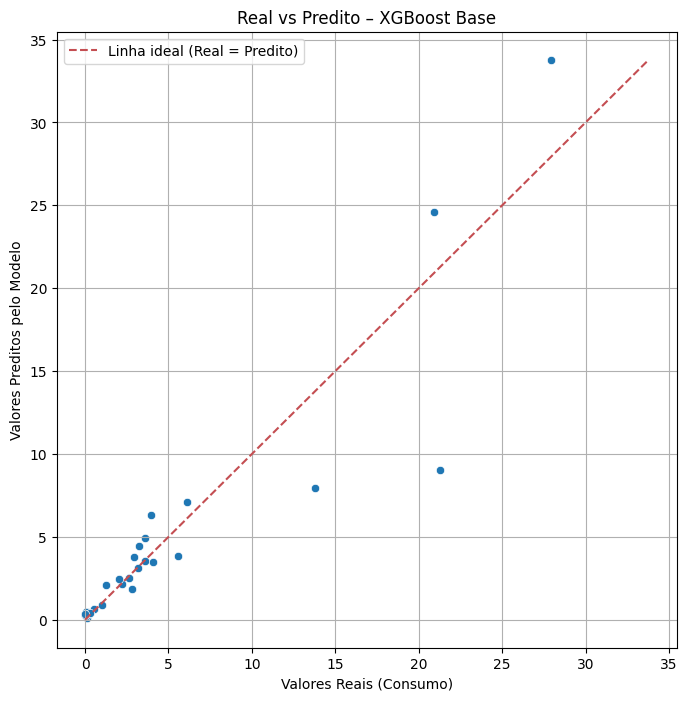

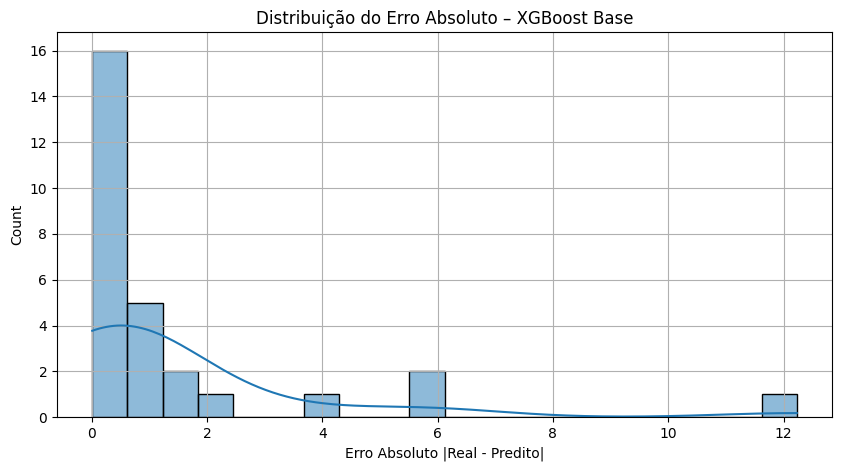

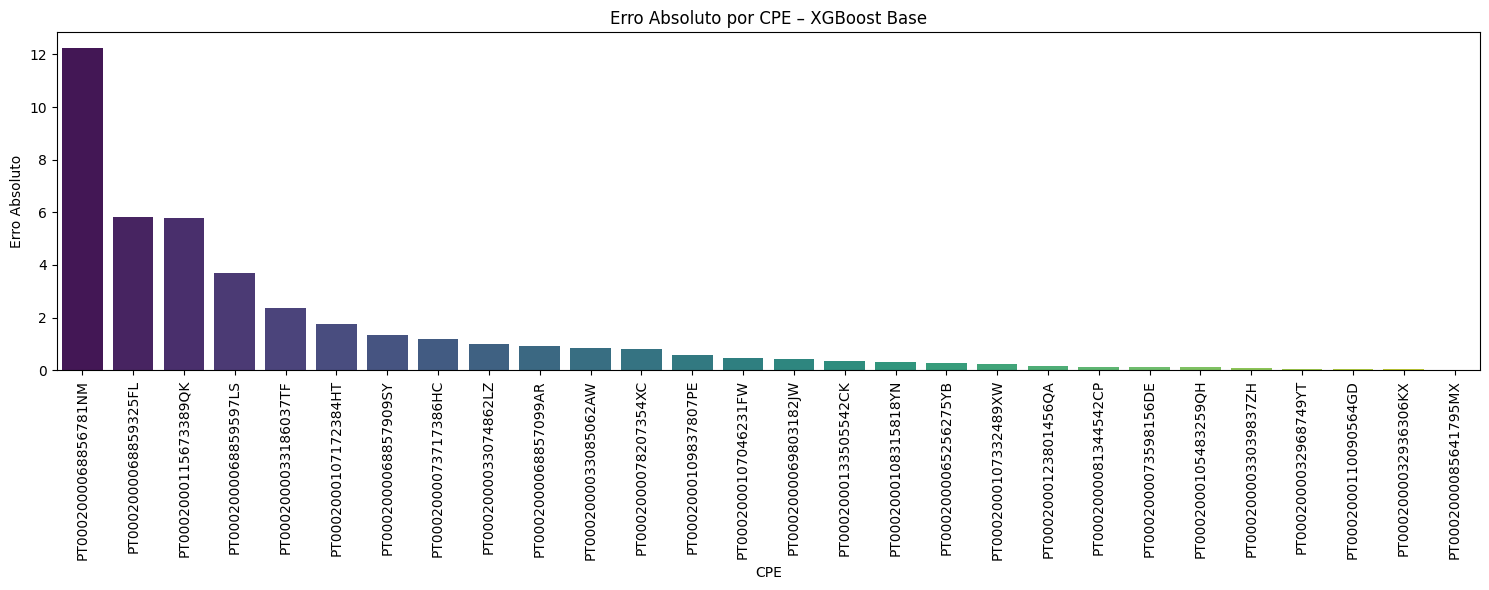

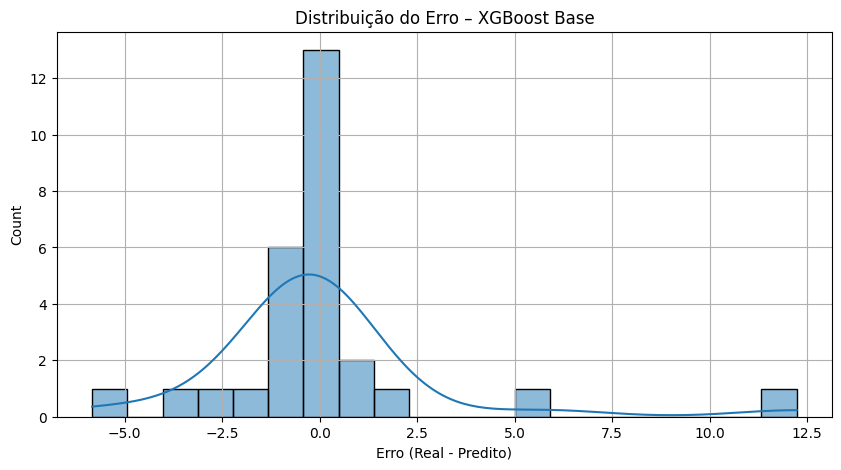

In [21]:
# Gráficos de avaliação XGBoost base

# 1. Real vs Predito
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_results["Real"], y=df_results["Predito"])
lim = [
    min(df_results["Real"].min(), df_results["Predito"].min()),
    max(df_results["Real"].max(), df_results["Predito"].max())
]
plt.plot(lim, lim, 'r--', label="Linha ideal (Real = Predito)")
plt.xlabel("Valores Reais (Consumo)")
plt.ylabel("Valores Preditos pelo Modelo")
plt.title("Real vs Predito – XGBoost Base")
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribuição dos erros absolutos
plt.figure(figsize=(10, 5))
sns.histplot(df_results["Erro_abs"], bins=20, kde=True)
plt.xlabel("Erro Absoluto |Real - Predito|")
plt.title("Distribuição do Erro Absoluto – XGBoost Base")
plt.grid(True)
plt.show()

# 3. Erro absoluto por CPE
plt.figure(figsize=(15, 6))
df_sorted = df_results.sort_values("Erro_abs", ascending=False)
sns.barplot(x=df_sorted.index, y=df_sorted["Erro_abs"], palette="viridis")
plt.xticks(rotation=90)
plt.title("Erro Absoluto por CPE – XGBoost Base")
plt.ylabel("Erro Absoluto")
plt.xlabel("CPE")
plt.tight_layout()
plt.show()

# 4. Histograma dos erros (positivos e negativos)
plt.figure(figsize=(10, 5))
sns.histplot(df_results["Erro"], bins=20, kde=True)
plt.xlabel("Erro (Real - Predito)")
plt.title("Distribuição do Erro – XGBoost Base")
plt.grid(True)
plt.show()

### 2.6 Importância das features – XGBoost

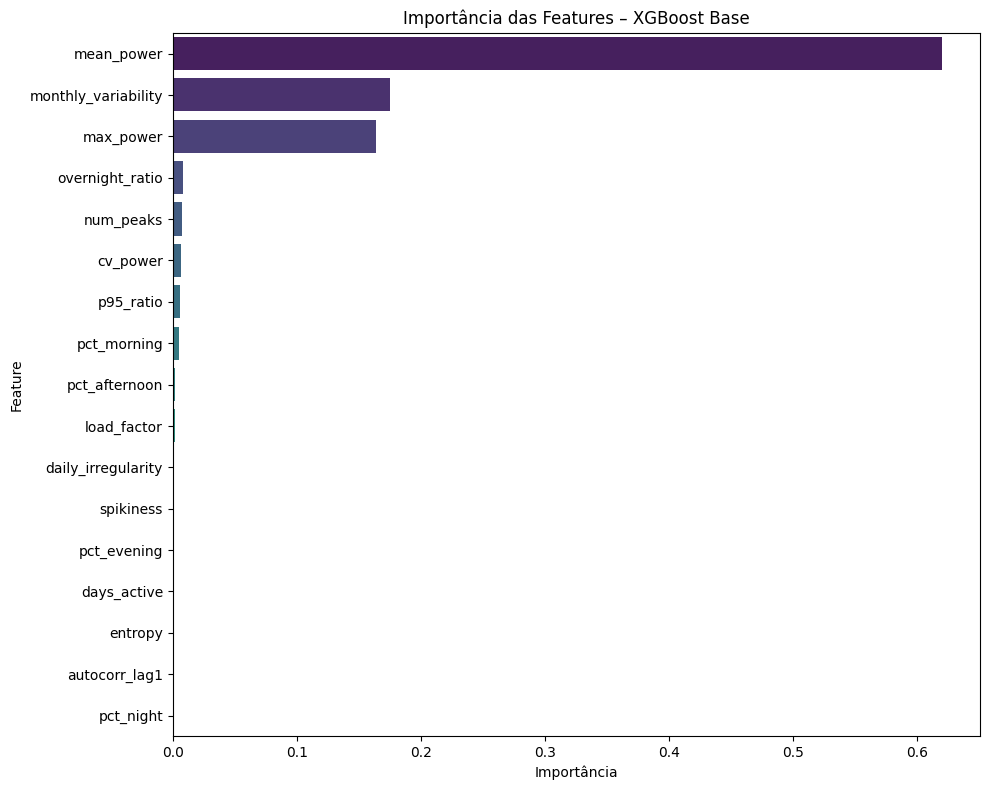

,Feature,Importance
0,mean_power,0.619956
11,monthly_variability,0.174926
1,max_power,0.163682
8,overnight_ratio,0.008510
12,num_peaks,0.007419
2,cv_power,0.006538
3,p95_ratio,0.005636
4,pct_morning,0.004984
5,pct_afternoon,0.001482
13,load_factor,0.001401


In [22]:
importances = model_xgb.feature_importances_
features = X_train.columns

df_imp = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Importância das Features – XGBoost Base")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

df_imp.head(20)

## 3. Random Forest Regressor

In [25]:
X = df_model.drop(columns=["target_next_week"])
y = df_model["target_next_week"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RANDOM FOREST – Métricas")
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("R² :", r2_rf)

df_results_rf = pd.DataFrame({
    "Real": y_test,
    "Predito_RF": y_pred_rf
})
df_results_rf["Erro_RF"] = df_results_rf["Real"] - df_results_rf["Predito_RF"]
df_results_rf["Erro_abs_RF"] = df_results_rf["Erro_RF"].abs()
df_results_rf.head()

RANDOM FOREST – Métricas
RMSE: 5.883784064857527
MAE: 2.3325447915451014
R² : 0.31068017588728514


,Real,Predito_RF,Erro_RF,Erro_abs_RF
CPE,,,,
PT0002000073717386HC,3.230312,4.654225,-1.423913,1.423913
PT0002000068856781NM,21.245926,27.241460,-5.995534,5.995534
PT0002000085641795MX,0.089147,0.135477,-0.046330,0.046330
PT0002000133505542CK,0.111988,14.596548,-14.484560,14.484560
PT0002000032936306KX,2.191508,2.134505,0.057003,0.057003


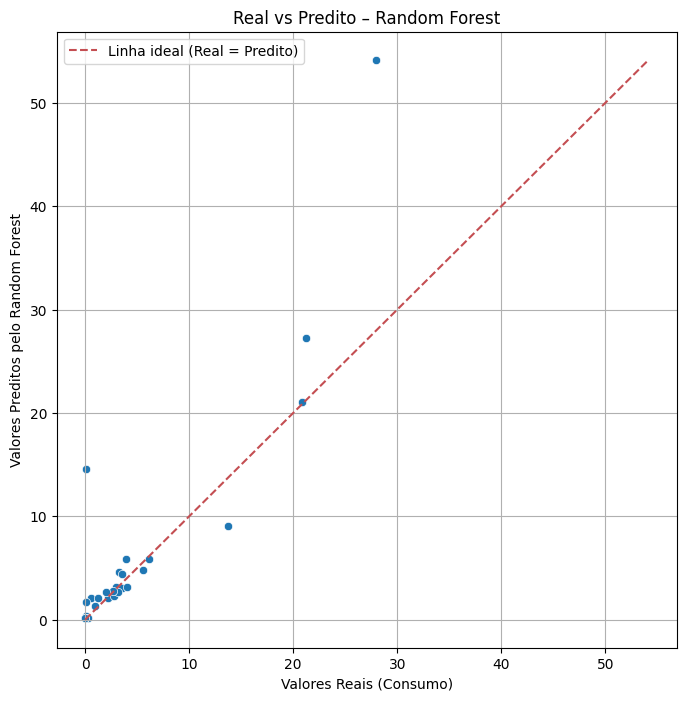

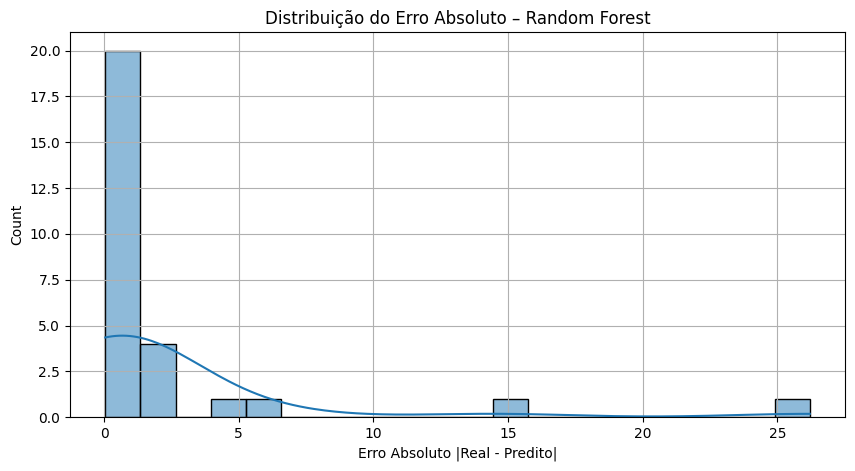

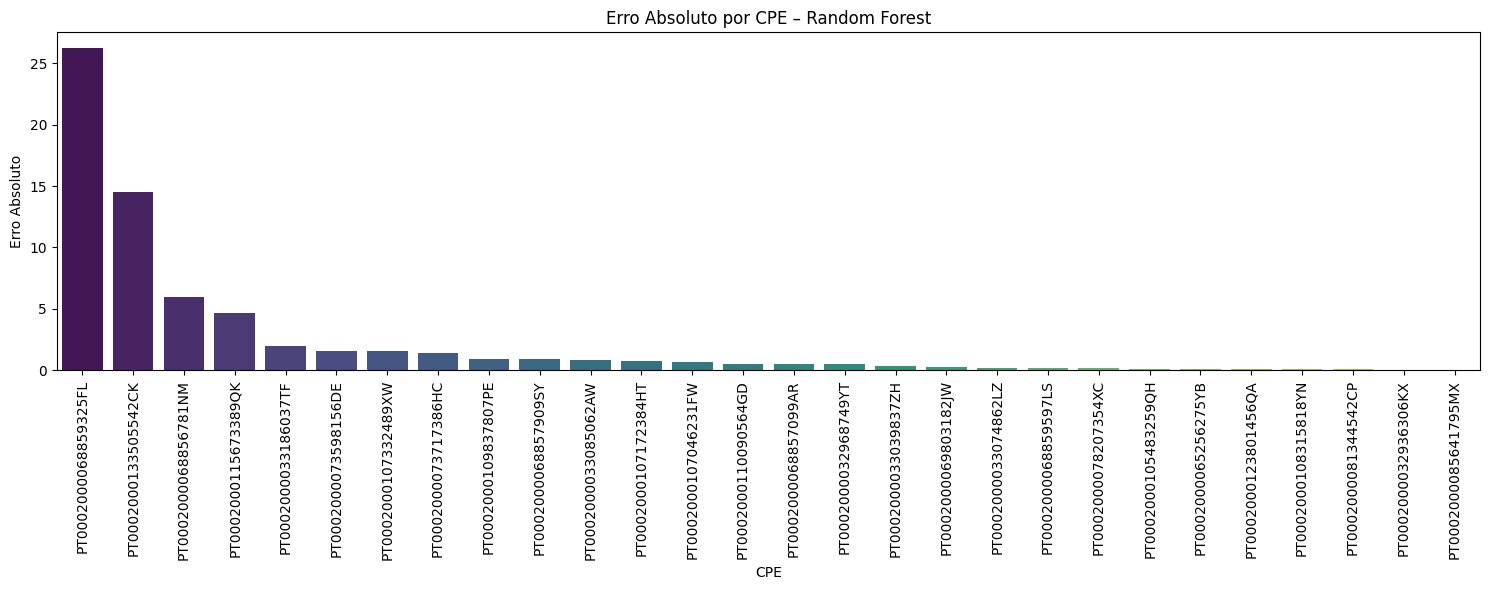

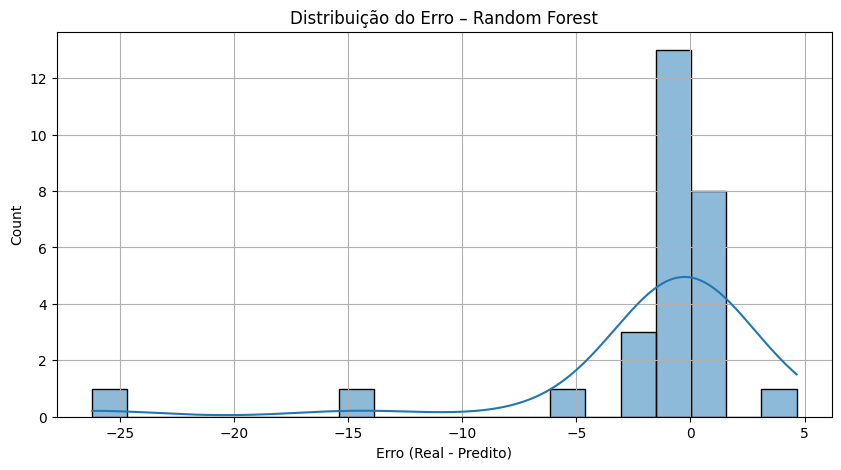

In [26]:
# Gráficos Random Forest

# 1. Real vs Predito
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_results_rf["Real"], y=df_results_rf["Predito_RF"])
lim = [
    min(df_results_rf["Real"].min(), df_results_rf["Predito_RF"].min()),
    max(df_results_rf["Real"].max(), df_results_rf["Predito_RF"].max())
]
plt.plot(lim, lim, 'r--', label="Linha ideal (Real = Predito)")
plt.xlabel("Valores Reais (Consumo)")
plt.ylabel("Valores Preditos pelo Random Forest")
plt.title("Real vs Predito – Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribuição do erro absoluto
plt.figure(figsize=(10, 5))
sns.histplot(df_results_rf["Erro_abs_RF"], bins=20, kde=True)
plt.xlabel("Erro Absoluto |Real - Predito|")
plt.title("Distribuição do Erro Absoluto – Random Forest")
plt.grid(True)
plt.show()

# 3. Erro por CPE
plt.figure(figsize=(15, 6))
df_sorted_rf = df_results_rf.sort_values("Erro_abs_RF", ascending=False)
sns.barplot(x=df_sorted_rf.index, y=df_sorted_rf["Erro_abs_RF"], palette="viridis")
plt.xticks(rotation=90)
plt.title("Erro Absoluto por CPE – Random Forest")
plt.ylabel("Erro Absoluto")
plt.xlabel("CPE")
plt.tight_layout()
plt.show()

# 4. Histograma dos erros
plt.figure(figsize=(10, 5))
sns.histplot(df_results_rf["Erro_RF"], bins=20, kde=True)
plt.xlabel("Erro (Real - Predito)")
plt.title("Distribuição do Erro – Random Forest")
plt.grid(True)
plt.show()

## 4. MLP Regressor (Rede Neural)

In [27]:
# Imputação e normalização para MLP
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)

rmse_mlp = mean_squared_error(y_test, y_pred_mlp) ** 0.5
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP – Métricas")
print("RMSE:", rmse_mlp)
print("MAE:", mae_mlp)
print("R² :", r2_mlp)

df_results_mlp = pd.DataFrame({
    "Real": y_test,
    "Predito_MLP": y_pred_mlp
})
df_results_mlp["Erro_MLP"] = df_results_mlp["Real"] - df_results_mlp["Predito_MLP"]
df_results_mlp["Erro_abs_MLP"] = df_results_mlp["Erro_MLP"].abs()
df_results_mlp.head()

MLP – Métricas
RMSE: 8.938912218799514
MAE: 3.6241411404986534
R² : -0.5910237478350431


,Real,Predito_MLP,Erro_MLP,Erro_abs_MLP
CPE,,,,
PT0002000073717386HC,3.230312,2.662540,0.567772,0.567772
PT0002000068856781NM,21.245926,5.492993,15.752932,15.752932
PT0002000085641795MX,0.089147,-0.060164,0.149311,0.149311
PT0002000133505542CK,0.111988,-1.062294,1.174282,1.174282
PT0002000032936306KX,2.191508,2.555199,-0.363691,0.363691


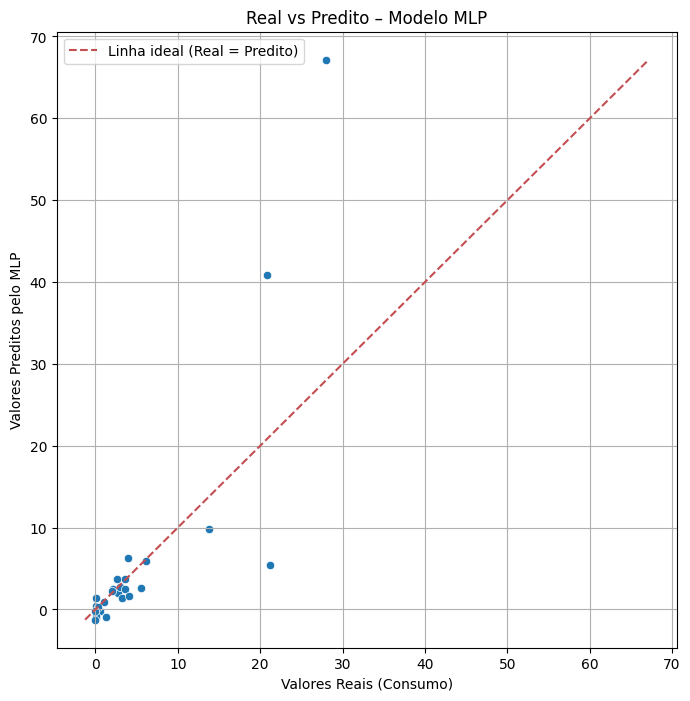

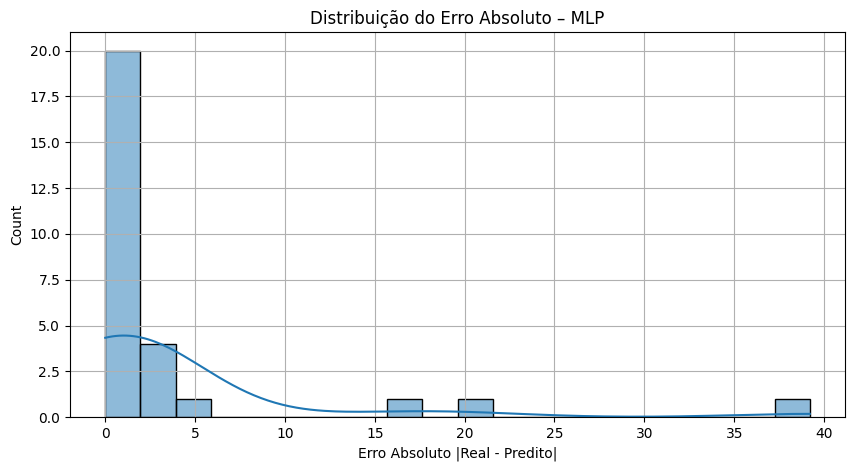

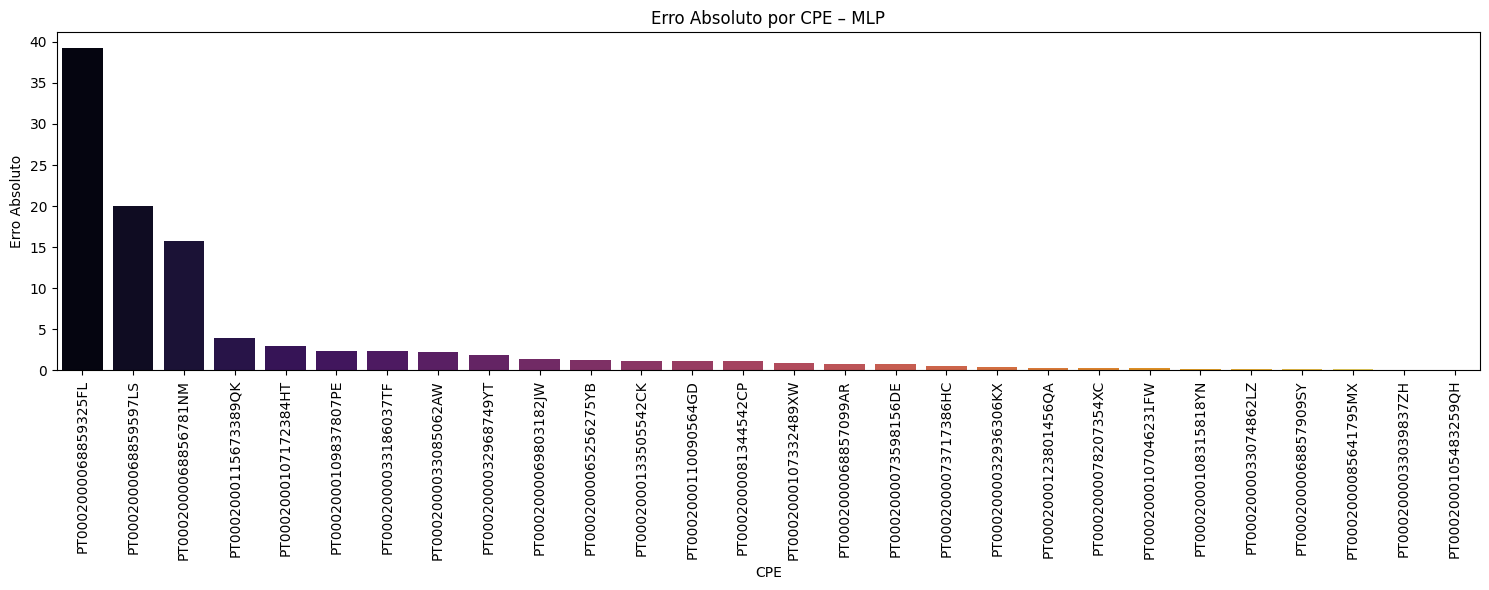

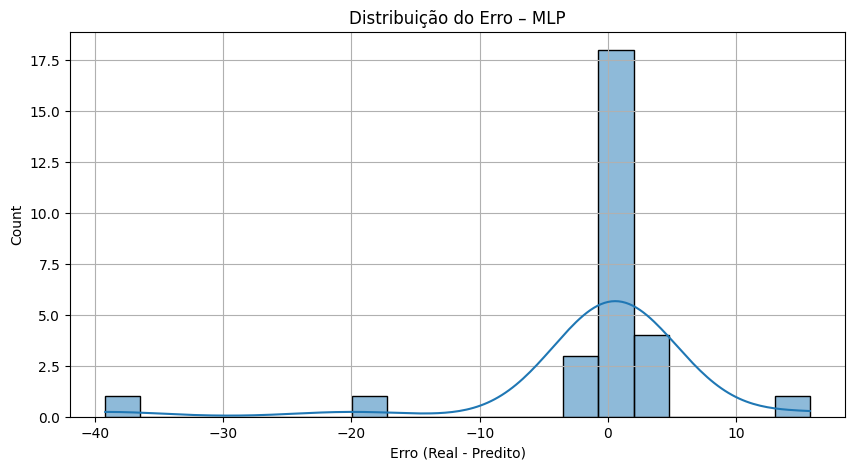

In [28]:
# Gráficos MLP

# 1. Real vs Predito
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_results_mlp["Real"], y=df_results_mlp["Predito_MLP"])
lim = [
    min(df_results_mlp["Real"].min(), df_results_mlp["Predito_MLP"].min()),
    max(df_results_mlp["Real"].max(), df_results_mlp["Predito_MLP"].max())
]
plt.plot(lim, lim, 'r--', label="Linha ideal (Real = Predito)")
plt.xlabel("Valores Reais (Consumo)")
plt.ylabel("Valores Preditos pelo MLP")
plt.title("Real vs Predito – Modelo MLP")
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribuição do Erro Absoluto
plt.figure(figsize=(10, 5))
sns.histplot(df_results_mlp["Erro_abs_MLP"], bins=20, kde=True)
plt.xlabel("Erro Absoluto |Real - Predito|")
plt.title("Distribuição do Erro Absoluto – MLP")
plt.grid(True)
plt.show()

# 3. Erro por CPE
plt.figure(figsize=(15, 6))
df_sorted_mlp = df_results_mlp.sort_values("Erro_abs_MLP", ascending=False)
sns.barplot(x=df_sorted_mlp.index, y=df_sorted_mlp["Erro_abs_MLP"], palette="inferno")
plt.xticks(rotation=90)
plt.title("Erro Absoluto por CPE – MLP")
plt.ylabel("Erro Absoluto")
plt.xlabel("CPE")
plt.tight_layout()
plt.show()

# 4. Histograma dos erros
plt.figure(figsize=(10, 5))
sns.histplot(df_results_mlp["Erro_MLP"], bins=20, kde=True)
plt.xlabel("Erro (Real - Predito)")
plt.title("Distribuição do Erro – MLP")
plt.grid(True)
plt.show()

## 5. Comparação entre XGBoost, Random Forest e MLP

In [29]:
comparison = pd.DataFrame({
    "Modelo": ["XGBoost", "Random Forest", "MLP"],
    "RMSE": [rmse, rmse_rf, rmse_mlp],
    "MAE": [mae, mae_rf, mae_mlp],
    "R²": [r2, r2_rf, r2_mlp]
})

print("Comparação Final dos Modelos")
display(comparison)

Comparação Final dos Modelos


,Modelo,RMSE,MAE,R²
0,XGBoost,2.972613,1.475142,0.824052
1,Random Forest,5.883784,2.332545,0.310680
2,MLP,8.938912,3.624141,-0.591024


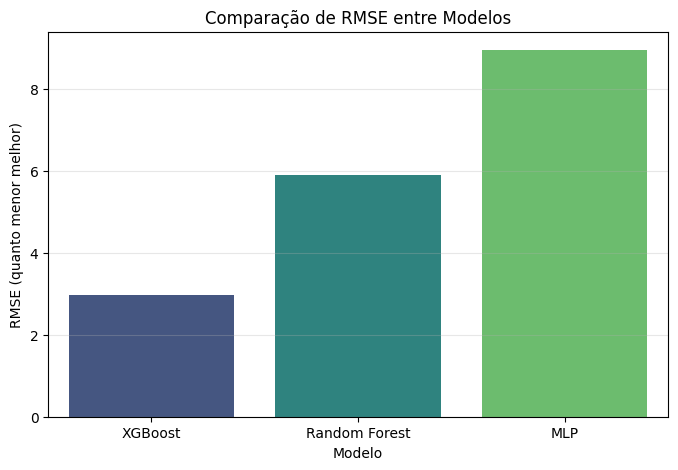

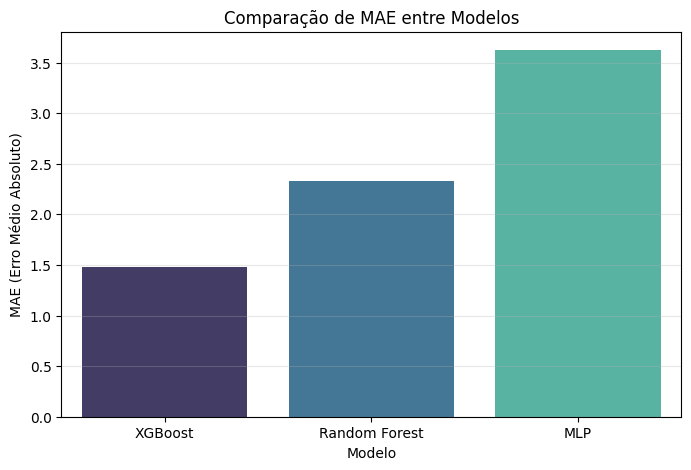

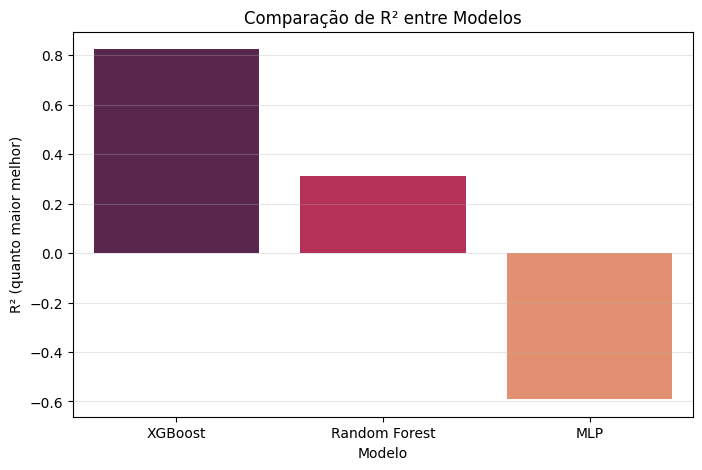

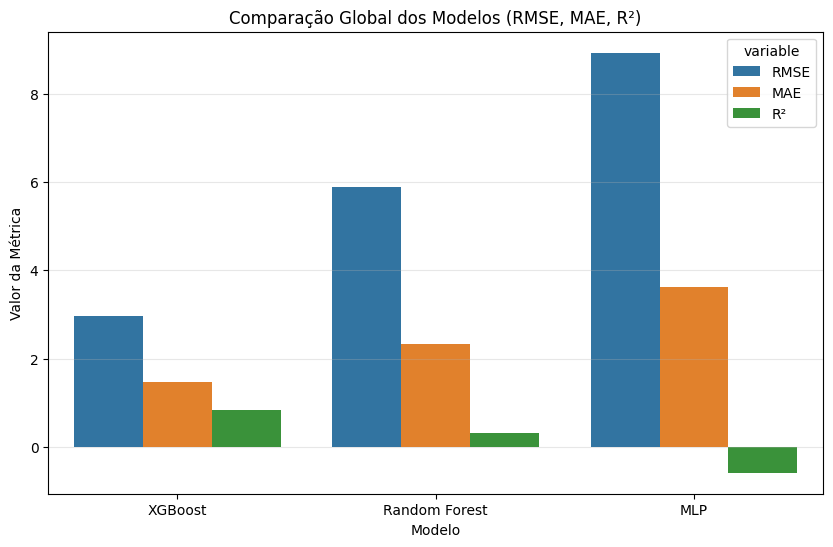

In [30]:
# Gráficos de comparação

# 1. RMSE
plt.figure(figsize=(8,5))
sns.barplot(data=comparison, x="Modelo", y="RMSE", palette="viridis")
plt.title("Comparação de RMSE entre Modelos")
plt.ylabel("RMSE (quanto menor melhor)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 2. MAE
plt.figure(figsize=(8,5))
sns.barplot(data=comparison, x="Modelo", y="MAE", palette="mako")
plt.title("Comparação de MAE entre Modelos")
plt.ylabel("MAE (Erro Médio Absoluto)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 3. R²
plt.figure(figsize=(8,5))
sns.barplot(data=comparison, x="Modelo", y="R²", palette="rocket")
plt.title("Comparação de R² entre Modelos")
plt.ylabel("R² (quanto maior melhor)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 4. Gráfico combinado
plt.figure(figsize=(10,6))
comparison_melted = comparison.melt(id_vars="Modelo", value_vars=["RMSE","MAE","R²"])
sns.barplot(data=comparison_melted, x="Modelo", y="value", hue="variable", palette="tab10")
plt.title("Comparação Global dos Modelos (RMSE, MAE, R²)")
plt.ylabel("Valor da Métrica")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## 6. Tuning Avançado do XGBoost (Random Search + Early Stopping)

In [31]:
import xgboost as xgb

df_features = features_clean.copy()
df_data = df_features.join(df_results[["Real"]], how="inner")  # usa Real como target consolidado

X = df_data.drop(columns=["Real"])
y = df_data["Real"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train_s, label=y_train)
dtest = xgb.DMatrix(X_test_s, label=y_test)

param_grid = {
    "max_depth": [3, 4, 5, 6],
    "eta": [0.01, 0.02, 0.05],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.5, 0.7, 0.9],
    "min_child_weight": [1, 3, 5],
    "lambda": [1, 1.5, 2],
    "alpha": [0, 0.5, 1]
}

search_params = []
for _ in range(30):
    combo = {
        "max_depth": np.random.choice(param_grid["max_depth"]),
        "eta": np.random.choice(param_grid["eta"]),
        "subsample": np.random.choice(param_grid["subsample"]),
        "colsample_bytree": np.random.choice(param_grid["colsample_bytree"]),
        "min_child_weight": np.random.choice(param_grid["min_child_weight"]),
        "lambda": np.random.choice(param_grid["lambda"]),
        "alpha": np.random.choice(param_grid["alpha"]),
        "objective": "reg:squarederror",
        "eval_metric": "rmse"
    }
    search_params.append(combo)

best_rmse = float("inf")
best_params = None

print("A procurar melhores parâmetros...\n")

for params in search_params:
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtest, "eval")],
        early_stopping_rounds=30,
        verbose_eval=False
    )
    rmse_val = model.best_score
    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_params = params

print("Melhores parâmetros encontrados:")
print(best_params)
print(f"RMSE em validação: {best_rmse:.4f}")

A procurar melhores parâmetros...

Melhores parâmetros encontrados:
{'max_depth': np.int64(5), 'eta': np.float64(0.05), 'subsample': np.float64(0.9), 'colsample_bytree': np.float64(0.9), 'min_child_weight': np.int64(3), 'lambda': np.float64(1.0), 'alpha': np.float64(0.0), 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
RMSE em validação: 1.8573



MÉTRICAS DO XGBOOST OTIMIZADO
RMSE: 1.8977
MAE:  1.3720
R²:   0.9265


<Figure size 1000x600 with 0 Axes>

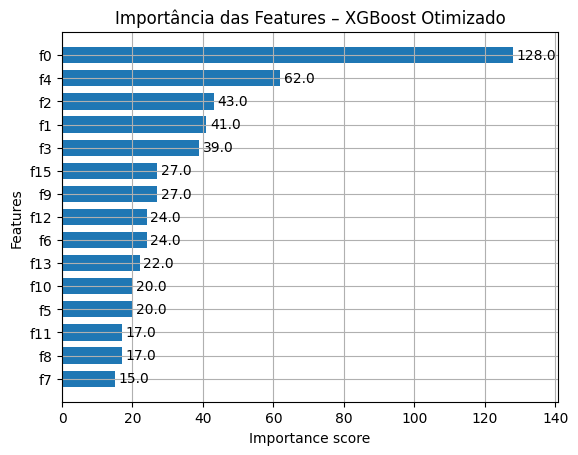

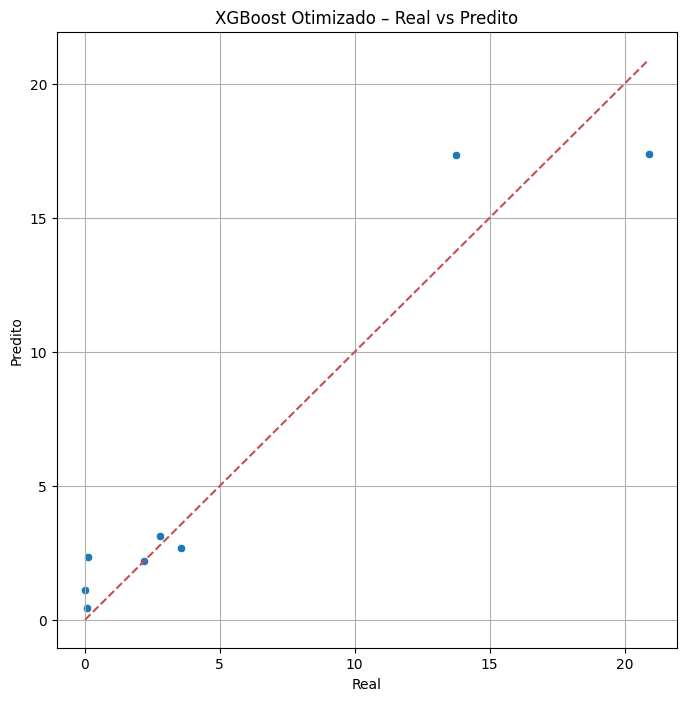

Top 10 CPE com maior erro absoluto (modelo otimizado):


,Real,Predito,Erro,Erro_abs
CPE,,,,
PT0002000115673389QK,13.760000,17.322239,-3.562239,3.562239
PT0002000068859597LS,20.890045,17.370493,3.519552,3.519552
PT0002000107332489XW,0.107597,2.345222,-2.237625,2.237625
PT0002000108315818YN,0.013076,1.107006,-1.093930,1.093930
PT0002000068857909SY,3.564636,2.688719,0.875917,0.875917
PT0002000069803182JW,0.075994,0.432784,-0.356790,0.356790
PT0002000085641795MX,0.089147,0.436878,-0.347731,0.347731
PT0002000068857099AR,2.784547,3.122944,-0.338397,0.338397
PT0002000032936306KX,2.191508,2.207056,-0.015547,0.015547


In [32]:
# Treino final com melhores parâmetros
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtest, "eval")],
    early_stopping_rounds=40,
    verbose_eval=False
)

y_pred_final = final_model.predict(dtest)

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\nMÉTRICAS DO XGBOOST OTIMIZADO")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAE:  {mae_final:.4f}")
print(f"R²:   {r2_final:.4f}")

df_eval = pd.DataFrame({
    "Real": y_test,
    "Predito": y_pred_final
})
df_eval["Erro"] = df_eval["Real"] - df_eval["Predito"]
df_eval["Erro_abs"] = df_eval["Erro"].abs()

# Importância das features
plt.figure(figsize=(10, 6))
xgb.plot_importance(final_model, max_num_features=15, height=0.7)
plt.title("Importância das Features – XGBoost Otimizado")
plt.show()

# Real vs Predito
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_eval["Real"], y=df_eval["Predito"])
lim = [
    min(df_eval["Real"].min(), df_eval["Predito"].min()),
    max(df_eval["Real"].max(), df_eval["Predito"].max())
]
plt.plot(lim, lim, "r--")
plt.xlabel("Real")
plt.ylabel("Predito")
plt.title("XGBoost Otimizado – Real vs Predito")
plt.grid(True)
plt.show()

print("Top 10 CPE com maior erro absoluto (modelo otimizado):")
display(df_eval.sort_values("Erro_abs", ascending=False).head(10))

## 7. Versões Alternativas Baseadas em Séries Temporais e Diagnóstico

In [33]:
def make_timeseries(df_raw, cpe, target="PotActiva", freq="15min",
                    max_na_ratio=0.2, min_len=96*3):
    """Constrói série temporal limpa para um CPE."""
    df_cpe = df_raw[df_raw["CPE"] == cpe].copy()
    if df_cpe.empty:
        return None

    df_cpe["tstamp"] = pd.to_datetime(df_cpe["tstamp"], errors="coerce")
    df_cpe = df_cpe.dropna(subset=["tstamp"]).sort_values("tstamp")
    df_cpe = df_cpe.groupby("tstamp")[target].mean().to_frame()
    df_cpe = df_cpe.asfreq(freq)

    if df_cpe[target].isna().mean() > max_na_ratio:
        return None

    df_cpe[target] = df_cpe[target].interpolate(limit_direction="both")
    if len(df_cpe) < min_len:
        return None

    return df_cpe[[target]]


def diagnose_cpe(df_raw):
    motivos = []
    for cpe in df_raw["CPE"].unique():
        try:
            ts = make_timeseries(df_raw, cpe, "PotActiva")
            if ts is None:
                motivos.append((cpe, "Série temporal inválida (curta, falhas ou NaN)"))
                continue
        except Exception as e:
            motivos.append((cpe, f"Erro inesperado: {e}"))
    return pd.DataFrame(motivos, columns=["CPE", "Motivo"])

df_diagnostico = diagnose_cpe(df_raw)
print("Total com problemas na série temporal:", df_diagnostico.shape[0])
display(df_diagnostico.head())

Total com problemas na série temporal: 2


,CPE,Motivo
0,PT0002000089069203YG,"Série temporal inválida (curta, falhas ou NaN)"
1,PT0002000079901964CJ,"Série temporal inválida (curta, falhas ou NaN)"


In [34]:
def get_last_week_mean(df_raw, cpe, target="PotActiva"):
    ts = make_timeseries(df_raw, cpe, target)
    if ts is None or len(ts) < 96*7:
        return None
    return ts.iloc[-96*7:][target].mean()


def predict_cpe_with_xgb(df_raw, df_feats, cpe):
    target = "PotActiva"
    real_value = get_last_week_mean(df_raw, cpe, target)
    if real_value is None:
        return None

    if cpe not in df_feats.index:
        return None
    
    x = df_feats.loc[cpe].values.reshape(1, -1)

    X_all = df_feats.values
    y_all = df_feats["PotActiva_mean"].values

    scaler_local = StandardScaler()
    X_scaled = scaler_local.fit_transform(X_all)
    x_scaled = scaler_local.transform(x)

    model_local = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    model_local.fit(X_scaled, y_all)
    pred = model_local.predict(x_scaled)[0]
    return real_value, pred

In [35]:
df_feats = features_clean.copy()

df_out = []
for cpe in df_feats.index:
    res = predict_cpe_with_xgb(df_raw, df_feats, cpe)
    if res is None:
        continue
    real, pred = res
    df_out.append([cpe, real, pred])

df_xgb_alt = pd.DataFrame(df_out, columns=["CPE", "Real", "Predito"]).set_index("CPE")

y_true_alt = df_xgb_alt["Real"]
y_pred_alt = df_xgb_alt["Predito"]

rmse_alt = mean_squared_error(y_true_alt, y_pred_alt) ** 0.5
mae_alt = mean_absolute_error(y_true_alt, y_pred_alt)
r2_alt = r2_score(y_true_alt, y_pred_alt)

print("MÉTRICAS – Versão Alternativa XGBoost (por CPE / séries temporais)")
print("RMSE:", rmse_alt)
print("MAE:", mae_alt)
print("R²:", r2_alt)

KeyError: 'PotActiva_mean'

In [ ]:
# Gráficos da versão alternativa

df_results_alt = df_xgb_alt.copy()
df_results_alt["Erro"] = df_results_alt["Real"] - df_results_alt["Predito"]
df_results_alt["Erro_abs"] = df_results_alt["Erro"].abs()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_results_alt["Real"], y=df_results_alt["Predito"], s=70)
lim = [
    min(df_results_alt["Real"].min(), df_results_alt["Predito"].min()),
    max(df_results_alt["Real"].max(), df_results_alt["Predito"].max())
]
plt.plot(lim, lim, 'r--', label="Predição Perfeita (y=x)")
plt.xlabel("Consumo Real (média da última semana)")
plt.ylabel("Consumo Predito pelo XGBoost (alternativo)")
plt.title("Real vs Predito – XGBoost (versão alternativa)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_results_alt["Erro_abs"], bins=20, kde=True)
plt.xlabel("Erro Absoluto")
plt.title("Distribuição do Erro Absoluto – XGBoost Alternativo")
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
df_sorted_alt = df_results_alt.sort_values("Erro_abs", ascending=False)
sns.barplot(x=df_sorted_alt.index, y=df_sorted_alt["Erro_abs"], palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Erro Absoluto")
plt.title("Erro Absoluto por CPE – XGBoost Alternativo")
plt.tight_layout()
plt.show()